#Segundo intento#



*   Solo con los datos de Madrid de Idealista2018
*   Madrid_Sale.csv y Madrid_Polygons.rda bajados de https://github.com/paezha/idealista18/tree/e2cfe3f621e1c37f226ce956f61b7306c42d5721/data


*   archivo Madrid_Polygons.rda transformado en csv con Notebook en R Script R rda a csv.ipyn https://colab.research.google.com/drive/1I06zwKUreseL1p87dHq0TzMheUHiEmVc


*   Exploración de datos (EDA) copiado de https://github.com/enricobonii/Idealista-Project/blob/main/IdealistaProject%20v4.ipynb
*Agregar la Columna neighbourhood a df_Madrid: de la latitud y longitud de cada casa se busca el barrio al que corresponde en Madrid_Polygons.csv


* a Madrid_Polygons se le añade la columna mean_UNITPRICE para utilizarla posteriormente para calcular precios de casas en 2024.

* Se intenta bajar la geometria de la M30, para calcular la distancia de los pisos a esta, y para definir si están dentro de la M30 o fuera. Como no funciona porque los datos de la M30 incluyen las carreteras radiales, y no se cierra, en las próximas versiones se desechará la M30

* Se calcula el número de estaciones de Metro que hay en un radio de 500m alrededor de cada casa, y se guarda en la nueva columna metro_within_500m

* finalmente, se guarda el dataframe como gdf_Madrid_with_metro_count.csv en el Google drive asi como Madrid_Polygons_with_mean_unitprice.csv

* lo siguiente, Multivariate Analysis etc. copiado de https://github.com/enricobonii/Idealista-Project/blob/main/IdealistaProject%20v4.ipynb no se ha tocado de momento





In [2]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Ruta al archivo CSV en Google Drive
file_path = '/content/drive/My Drive/Idealista_2024/datos_2018/'

Mounted at /content/drive


In [3]:
from getpass import getpass
import os

# Solicita el token personal de GitHub
token = getpass('GitHub Token: ')

# Define la URL del repositorio y la ruta de clonación
repo_url = "https://github.com/edouardor/Idealista_2024.git"
destino = "/content/drive/MyDrive/Idealista_2024"

# Clona el repositorio en la carpeta de Google Drive
os.system(f'git clone https://{token}@github.com/edouardor/Idealista_2024.git {destino}')


GitHub Token: ··········


32768

In [4]:
!ls -a


.  ..  .config	drive  sample_data


In [12]:
!git config --global user.email "edouardo@hotmail.es"
!git config --global user.name "edouardor"

In [24]:
# Agregar los archivos modificados
!git add .

# Hacer un commit
!git commit -m "Actualización desde Google Colab"

# Hacer push de los cambios
!git push


[main b4b7564] Actualización desde Google Colab
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Notebooks/Idealista Madrid github.ipynb (85%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.72 KiB | 29.00 KiB/s, done.
Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/edouardor/Idealista_2024.git
   7c8d851..b4b7564  main -> main


**Para ver las diferencias con el notebook anterior:**

*descomentar las lineas siguientes*

In [27]:
#!pip install nbdime
#!nbdiff Notebooks/"Idealista Madrid github.ipynb"


In [14]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_columns', None)

## Initializing Datasets

###Solo Madrid


In [18]:

df= pd.read_csv(file_path+'gdf_Madrid_with_metro_count.csv')


In [19]:
df.head(3)

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m
0,A2624736749193113090,4,166000,1844.444444,HOME,SALE,90,2,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1.0,1986,10,32,5.0,0,0,1,7.953755,0.402011,6.504196,-3.611866,40.431013,Madrid,HOME,SALE,Hellín,2
1,A8841356095019025740,3,133000,1727.272727,HOME,SALE,77,3,1,1,1,1,3,0,0,1,1,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,4,80,7.0,0,0,1,7.443821,0.480740,5.961369,-3.618239,40.431754,Madrid,HOME,SALE,Hellín,1
2,A6716251930495709236,3,98000,1719.298246,HOME,SALE,57,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1960,4,9,7.0,0,0,1,7.473113,0.287270,6.039694,-3.617411,40.430101,Madrid,HOME,SALE,Hellín,1


## Exploratory Data Analysis

In [20]:
print(df.dtypes)

ASSETID                     object
PERIOD                       int64
PRICE                        int64
UNITPRICE                  float64
ADTYPOLOGYID                object
ADOPERATIONID               object
CONSTRUCTEDAREA              int64
ROOMNUMBER                   int64
BATHNUMBER                   int64
HASTERRACE                   int64
HASLIFT                      int64
HASAIRCONDITIONING           int64
AMENITYID                    int64
HASPARKINGSPACE              int64
HASNORTHORIENTATION          int64
HASSOUTHORIENTATION          int64
HASEASTORIENTATION           int64
HASWESTORIENTATION           int64
HASBOXROOM                   int64
HASWARDROBE                  int64
HASSWIMMINGPOOL              int64
HASDOORMAN                   int64
HASGARDEN                    int64
ISDUPLEX                     int64
ISSTUDIO                     int64
ISINTOPFLOOR                 int64
FLOORCLEAN                 float64
FLATLOCATIONID             float64
CADCONSTRUCTIONYEAR 

From here we can observe that the formatted variable types make sense with the expected and are homogeneous among the different datasets.

In [21]:
df.describe(include='all')

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m
count,75740,75740.000000,7.574000e+04,75740.000000,75740,75740,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740,75740,75740,75740,75740.000000
unique,75740,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,135,NaN
top,A2624736749193113090,NaN,NaN,NaN,HOME,SALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Madrid,HOME,SALE,Lavapiés-Embajadores,NaN
freq,1,NaN,NaN,NaN,75740,75740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75740,75740,75740,2947,NaN
mean,NaN,2.784500,3.885028e+05,3632.521702,NaN,NaN,100.217586,2.570148,1.570240,0.351149,0.689213,0.439041,2.924835,0.216794,0.104383,0.231344,0.196343,0.142831,0.249908,0.563982,0.141907,0.247320,0.176657,0.025297,0.027079,0.021495,2.714840,0.871283,1965.446409,6.360536,38.695801,4.870399,0.031780,0.186903,0.781318,4.474552,0.469338,2.675121,-3.686323,40.420673,NaN,NaN,NaN,NaN,1.457182
std,NaN,1.209515,4.124885e+05,1708.417808,NaN,NaN,66.433670,1.246913,0.835428,0.477332,0.462819,0.496273,0.313232,0.412064,0.305759,0.421695,0.397233,0.349902,0.432962,0.495893,0.348957,0.431457,0.381381,0.157027,0.162316,0.145027,2.211571,0.334888,28.916426,2.843000,53.290795,1.460220,0.175414,0.389836,0.413355,2.669527,0.593230,2.199341,0.038916,0.033458,NaN,NaN,NaN,NaN,1.314439
min,NaN,1.000000,2.100000e+04,805.309734,NaN,NaN,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1623.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.007647,0.001416,0.001435,-3.832534,40.328682,NaN,NaN,NaN,NaN,0.000000
25%,NaN,2.000000,1.570000e+05,2200.000000,NaN,NaN,62.000000,2.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1955.000000,5.000000,12.000000,4.000000,0.000000,0.000000,1.000000,2.401815,0.212906,1.040583,-3.708313,40.396519,NaN,NaN,NaN,NaN,0.000000
50%,NaN,3.000000,2.560000e+05,3440.000000,NaN,NaN,82.000000,3.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1967.000000,6.000000,21.000000,5.000000,0.000000,0.000000,1.000000,4.112561,0.329996,1.961970,-3.694002,40.423025,NaN,NaN,NaN,NaN,1.000000
75%,NaN,4.000000,4.560000e+05,4719.558389,NaN,NaN,115.000000,3.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1983.000000,8.000000,39.000000,6.000000,0.000000,0.000

In [22]:
# prompt: drop observertions where df[df['ROOMNUMBER']>20]

df = df[df['ROOMNUMBER'] <= 20]

## Multivariate Analysis

**Voy a cambiar la LATITUD y LONGITUD por la distancia en km a Nuevos Ministerios (AZCA), medida como si fuera una cuadrícula**

mido la distancia a un punto con la misma latitud que AZCA, y a otro con la misma longitud


*The coordinates are converted from latitude and longitude to northing and easting in meters, and then rescaled and centered using the corresponding city’s Central Business District as a false origin. These transformations have no impact on the analysis, and rescaling and centering of the coordinates is necessary for the correct implementation of the interactive basis functions in decision trees (see Antonio Paez et al. 2019, 188–89). https://github.com/paezha/Machine-learning-for-market-segmentation*

In [29]:
# Definir la función de Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radio de la Tierra en km

    # Convertir las coordenadas de grados a radianes
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    # Aplicar la fórmula de Haversine
    a = np.sin(delta_phi / 2.0) ** 2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


# Coordenadas del punto de referencia
,
ref_lat = 40.446195
ref_lon = -3.691269

# Calcular las distancias
# Crear nuevas columnas 'DISTANCIA_LATITUD' y 'DISTANCIA_LONGITUD'
df['DISTANCIA_LATITUD'] = haversine(df['LATITUDE'], ref_lon, ref_lat, ref_lon)
df['DISTANCIA_LONGITUD'] = haversine(ref_lat, df['LONGITUDE'], ref_lat, ref_lon)

# Mostrar el DataFrame resultante
print(df.head())


                ASSETID  PERIOD   PRICE    UNITPRICE ADTYPOLOGYID  \
0  A2624736749193113090       4  166000  1844.444444         HOME   
1  A8841356095019025740       3  133000  1727.272727         HOME   
2  A6716251930495709236       3   98000  1719.298246         HOME   
3  A1897858214850462442       4  125000  2016.129032         HOME   
4   A602619672115044517       3  111000  1947.368421         HOME   

  ADOPERATIONID  CONSTRUCTEDAREA  ROOMNUMBER  BATHNUMBER  HASTERRACE  HASLIFT  \
0          SALE               90           2           1           0        1   
1          SALE               77           3           1           1        1   
2          SALE               57           2           1           0        0   
3          SALE               62           3           1           0        0   
4          SALE               57           2           1           0        0   

   HASAIRCONDITIONING  AMENITYID  HASPARKINGSPACE  HASNORTHORIENTATION  \
0                   0   

In [ ]:
# Correlation analysis
'''
#CHANGE THE COLUMN CADCONSTRUCTIONYEAR datatype from int to year
df_Barcelona['CADCONSTRUCTIONYEAR'] = pd.to_datetime(df_Barcelona['CADCONSTRUCTIONYEAR'], format='%Y')
df_Barcelona['CADCONSTRUCTIONYEAR'] = df_Barcelona['CADCONSTRUCTIONYEAR'].dt.year

#Add a column CadBuildingAge in barcelona dataset where age is current year - cadconstructionyear
barcelona['CADBUILDINGAGE'] = dt.datetime.now().year - barcelona['CADCONSTRUCTIONYEAR']
barcelona = barcelona.drop(columns=['CADCONSTRUCTIONYEAR'])
'''

"\n#CHANGE THE COLUMN CADCONSTRUCTIONYEAR datatype from int to year\ndf_Barcelona['CADCONSTRUCTIONYEAR'] = pd.to_datetime(df_Barcelona['CADCONSTRUCTIONYEAR'], format='%Y')\ndf_Barcelona['CADCONSTRUCTIONYEAR'] = df_Barcelona['CADCONSTRUCTIONYEAR'].dt.year\n\n#Add a column CadBuildingAge in barcelona dataset where age is current year - cadconstructionyear\nbarcelona['CADBUILDINGAGE'] = dt.datetime.now().year - barcelona['CADCONSTRUCTIONYEAR']\nbarcelona = barcelona.drop(columns=['CADCONSTRUCTIONYEAR'])\n"

As per the above table, we can see that the columns CONSTRUCTEDAREA, BATHNUMBER, ROOMNUMBER, HASPARKINGSPACE, DISTANCE_TO_DIAGONAL, CADASTRALQUALITYID, ISPARKINGSPACEINCLUDEDINPRICE, HASDOORMAN, HASLIFT, HASTERRACE are some of the columns that have a higher correlation with the PRICE of the asset listed.


<Figure size 1600x1100 with 0 Axes>

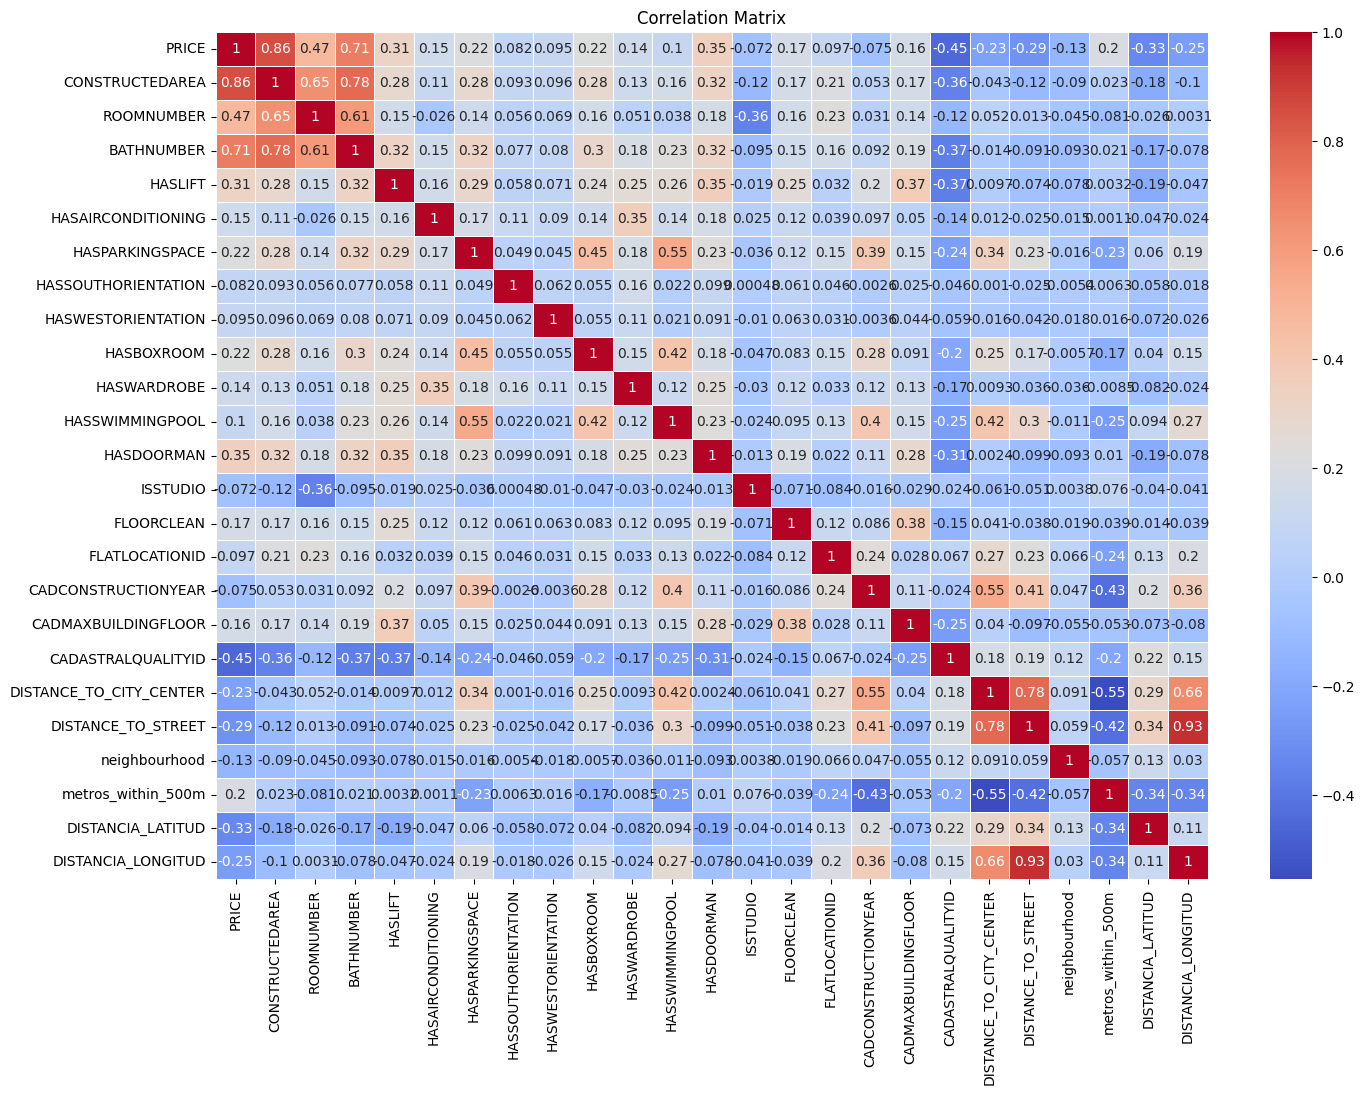

In [30]:
madrid = df.drop(columns=['ADOPERATIONID', 'UNITPRICE', 'LATITUDE', 'LONGITUDE','AMENITYID','ASSETID','ADTYPOLOGY','CITYNAME','ADOPERATION','ADTYPOLOGYID'])

# Encode the location names (label encoding)
madrid['neighbourhood'] = df['neighbourhood'].astype('category').cat.codes

plt.figure(figsize=(16, 11))
correlation_madrid = madrid.corr()

# Identify columns where absolute correlation with 'PRICE' is less than 0.07
low_corr_columns = correlation_madrid['PRICE'][abs(correlation_madrid['PRICE']) < 0.07].index

# Drop the identified columns from the DataFrame
madrid_filtered = madrid.drop(columns=low_corr_columns)

plt.figure(figsize=(16, 11))
correlation_madrid = madrid_filtered.corr()
sns.heatmap(correlation_madrid, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [31]:
print(madrid.dtypes)

PERIOD                       int64
PRICE                        int64
CONSTRUCTEDAREA              int64
ROOMNUMBER                   int64
BATHNUMBER                   int64
HASTERRACE                   int64
HASLIFT                      int64
HASAIRCONDITIONING           int64
HASPARKINGSPACE              int64
HASNORTHORIENTATION          int64
HASSOUTHORIENTATION          int64
HASEASTORIENTATION           int64
HASWESTORIENTATION           int64
HASBOXROOM                   int64
HASWARDROBE                  int64
HASSWIMMINGPOOL              int64
HASDOORMAN                   int64
HASGARDEN                    int64
ISDUPLEX                     int64
ISSTUDIO                     int64
ISINTOPFLOOR                 int64
FLOORCLEAN                 float64
FLATLOCATIONID             float64
CADCONSTRUCTIONYEAR          int64
CADMAXBUILDINGFLOOR          int64
CADDWELLINGCOUNT             int64
CADASTRALQUALITYID         float64
BUILTTYPEID_1                int64
BUILTTYPEID_2       

In [32]:
# print list of columns from correlation matrix in decreasing order of correlation with Price
correlation_madrid['PRICE'].sort_values(ascending=False)

,PRICE
PRICE,1.000000
CONSTRUCTEDAREA,0.856451
BATHNUMBER,0.712037
ROOMNUMBER,0.471946
HASDOORMAN,0.345088
HASLIFT,0.314891
HASBOXROOM,0.221086
HASPARKINGSPACE,0.215118
metros_within_500m,0.196744
FLOORCLEAN,0.173261


As per the above table, in Madrid,, we can see that the columns CONSTRUCTEDAREA, BATHNUMBER, ROOMNUMBER, HASDOORMAN, HASLIFT, HASPARKINGSPACE, metro_within_500 m, FloorClean are some of the columns that have a higher correlation with the PRICE of the asset listed.

**Analysing the pricing of assets based on location**

<ipython-input-33-91ba5e97af2c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='UNITPRICE', y='neighbourhood', data=average_prices, palette='viridis')


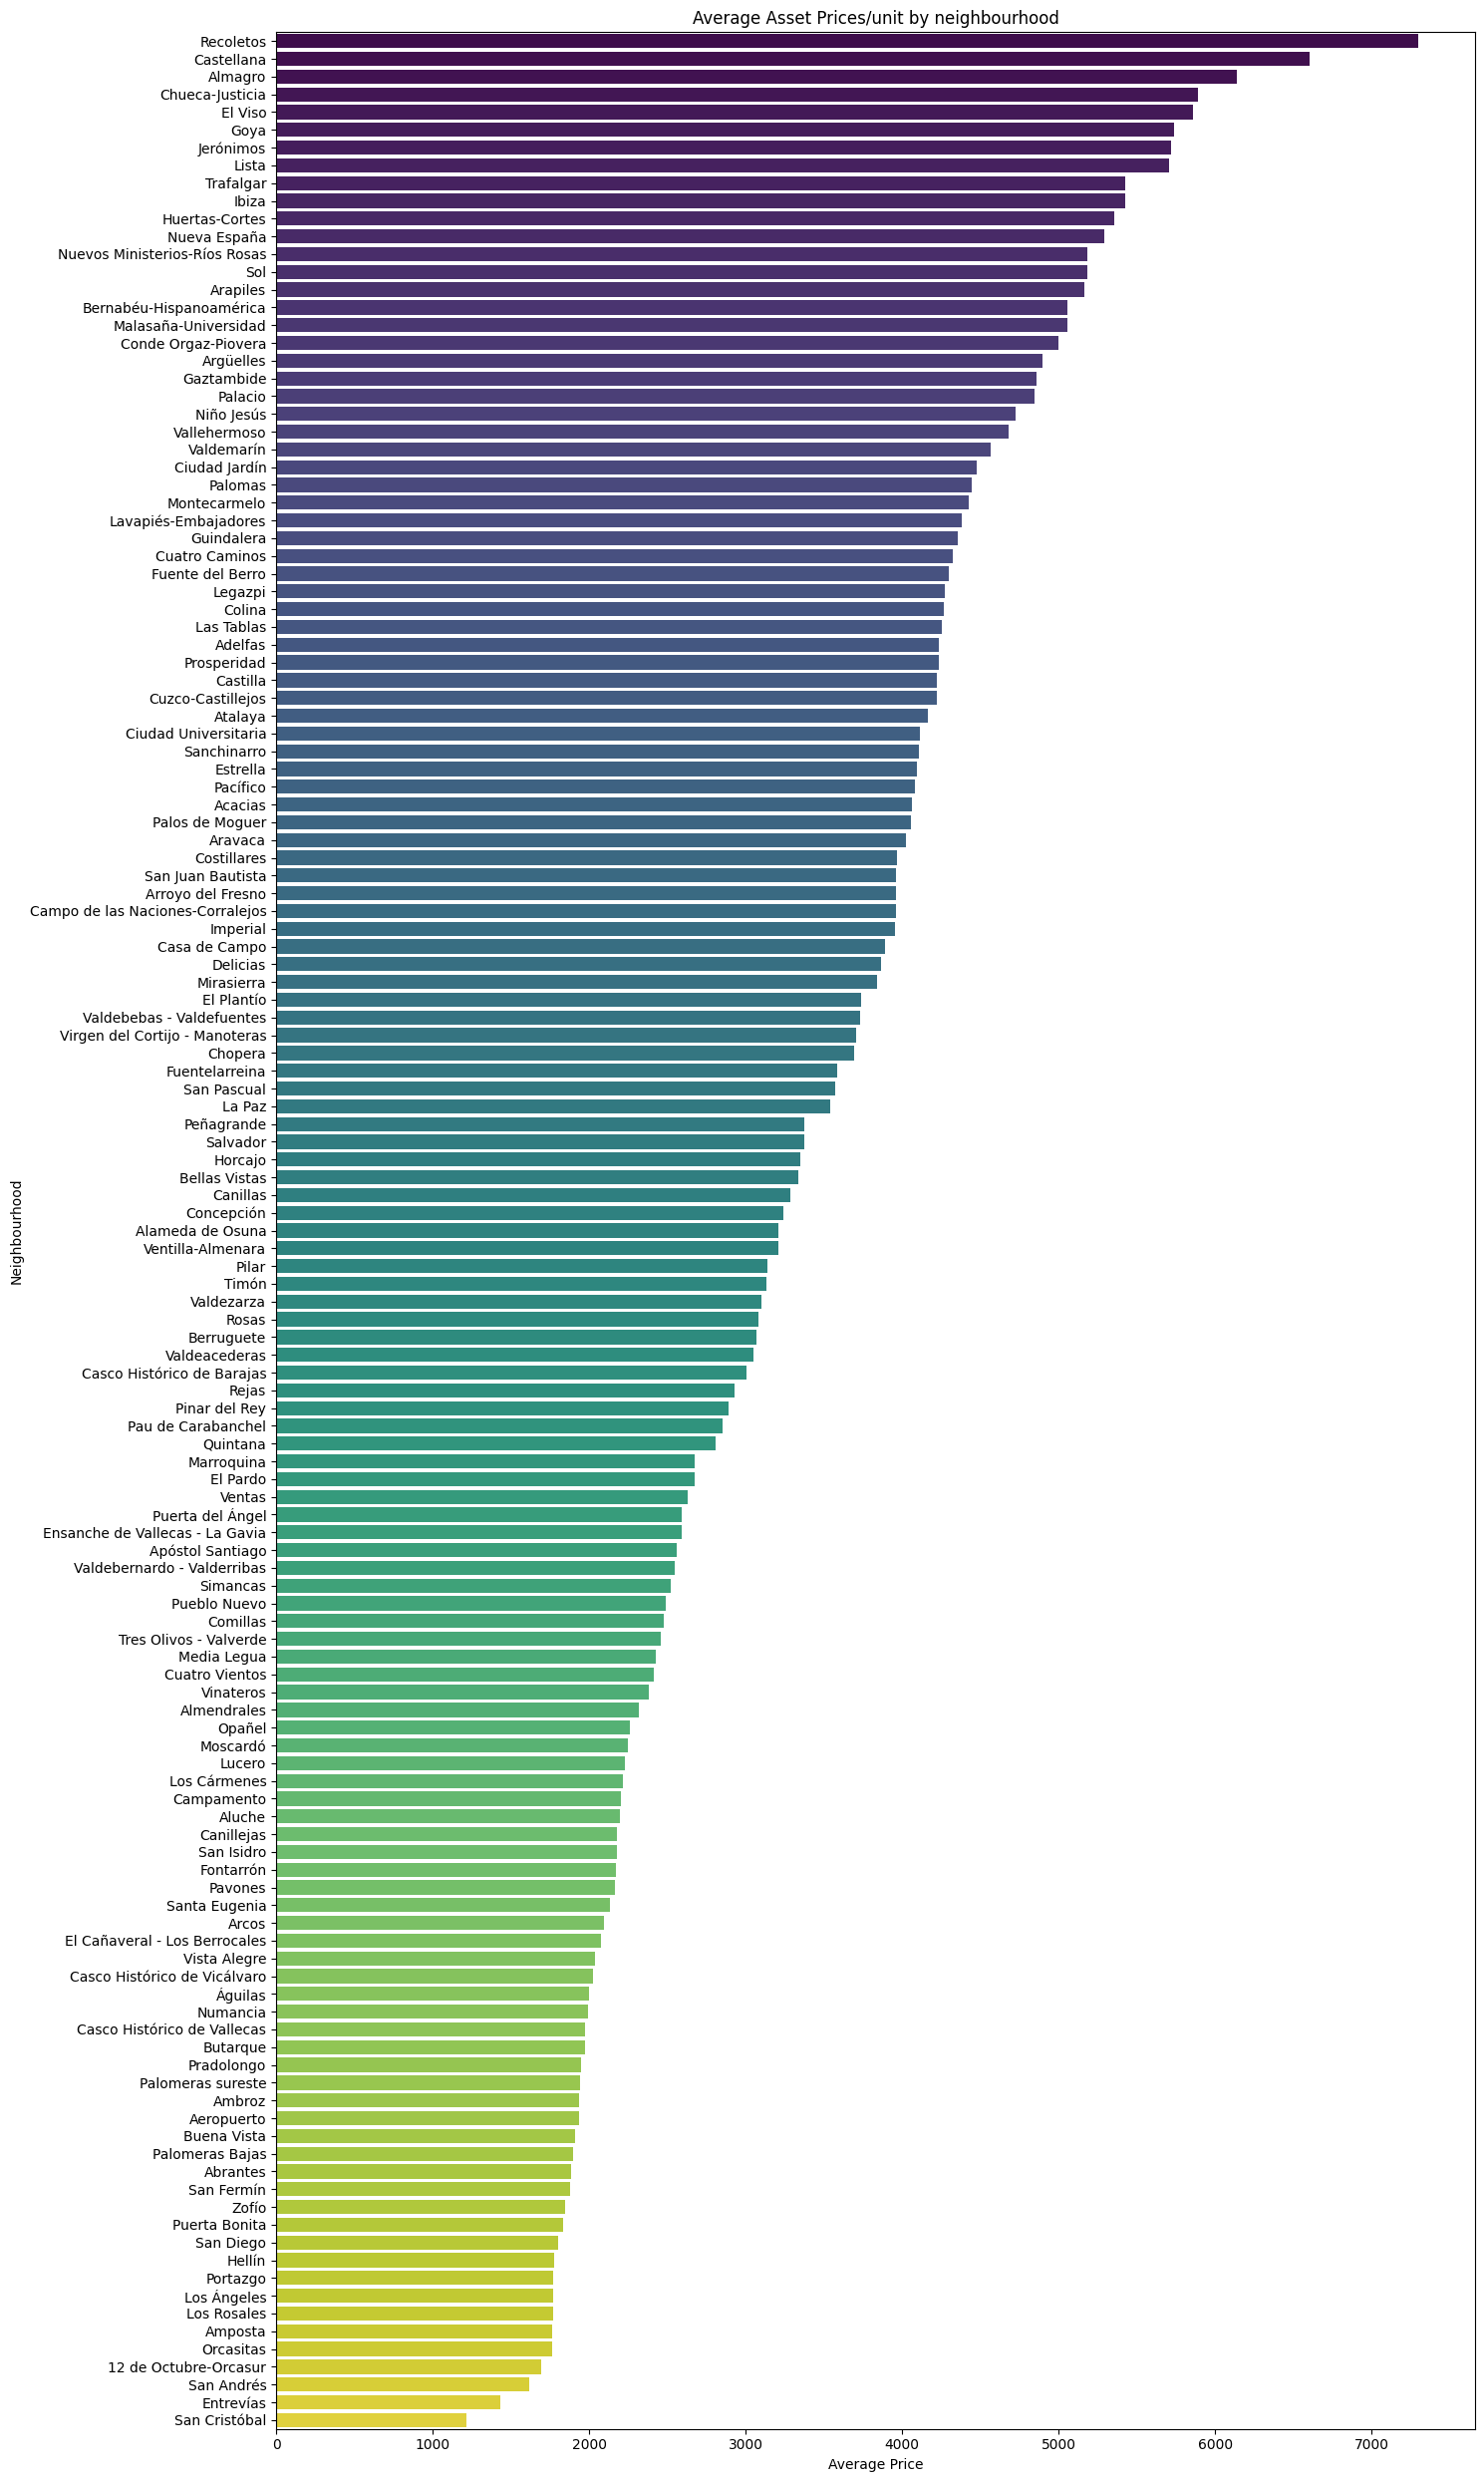

In [33]:
madrid_unit = df.copy()
# Encode the location names (label encoding)
madrid_unit['neighbourhood'] = df['neighbourhood'].astype('category').cat.codes

# Calculate average price by neighbourhood
average_prices = madrid_unit.groupby('neighbourhood')['UNITPRICE'].mean().reset_index()

#Map the neighbourhoods to their respective names
neighbourhood_map = dict(zip(madrid_unit['neighbourhood'], df['neighbourhood']))
average_prices['neighbourhood'] = average_prices['neighbourhood'].map(neighbourhood_map)

# Sort the neighbourhoods by average price in descending order
average_prices = average_prices.sort_values(by='UNITPRICE', ascending=False)

# Plot the average prices by neighbourhood
plt.figure(figsize=(15, 25))
sns.barplot(x='UNITPRICE', y='neighbourhood', data=average_prices, palette='viridis')

plt.title('Average Asset Prices/unit by neighbourhood')
plt.ylabel('Neighbourhood')
plt.xlabel('Average Price')
plt.tight_layout()

# Show the plot
plt.show()

As we see above, in Madrid, the neighbourhoods with the highest average asset unit prices (price per meter square) are: Recoletos, Castellana, Almagro, and Chueca. So the asset to be listed in/around these areas can have a high asking price (around 6500/m2). Places such as San Andres, Entrevias or San Cristobal have the lowest average asset prices. So the asset to be listed in/around these areas can have a low asking price (around 1300/m2).

In [34]:
madrid_unit['neighbourhood'].value_counts()

,count
neighbourhood,
67,2947
74,2094
57,1636
58,1483
100,1395
...,...
4,35
60,33
48,32


In [58]:
df_Madrid = df.copy()

## ML Models

**Cambiamos el precio por su logaritmo neperiano, para tener una distrubución más normal**

In [48]:
df_Madrid['PRICE'] = df_Madrid['PRICE'].apply(lambda x: np.log(x) if x > 0 else 0)

**Y en vez de poner el nombre del barrio, ponemos la media/m^2 en función del periodo**

*no sé hasta que punto, cuando hagamos el train/test split, deberíamos usar solo los datos del train para calcular la media - pero como hay muchos, no creo que cambie sustancialmente*

In [59]:
# Calcular la media de UNITPRICE para cada combinacion de 'neighbourhood' y 'PERIOD'
df_Madrid['MEAN_UNITPRICE'] = df_Madrid.groupby(['neighbourhood', 'PERIOD'])['UNITPRICE'].transform('mean')

**Vamos a cambiar el precio medio por su logarítmo, para ser coherentes con el cambio por el logarítmo del Precio**

In [50]:
df_Madrid['MEAN_UNITPRICE'] = df_Madrid['MEAN_UNITPRICE'].apply(lambda x: np.log(x) if x > 0 else 0)

In [60]:
df_Madrid.head()

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m,DISTANCIA_LATITUD,DISTANCIA_LONGITUD,MEAN_UNITPRICE
0,A2624736749193113090,4,166000,1844.444444,HOME,SALE,90,2,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1.0,1986,10,32,5.0,0,0,1,7.953755,0.402011,6.504196,-3.611866,40.431013,Madrid,HOME,SALE,Hellín,2,1.688116,6.719162,1898.550087
1,A8841356095019025740,3,133000,1727.272727,HOME,SALE,77,3,1,1,1,1,3,0,0,1,1,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,4,80,7.0,0,0,1,7.443821,0.480740,5.961369,-3.618239,40.431754,Madrid,HOME,SALE,Hellín,1,1.605735,6.179863,1760.246263
2,A6716251930495709236,3,98000,1719.298246,HOME,SALE,57,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1960,4,9,7.0,0,0,1,7.473113,0.287270,6.039694,-3.617411,40.430101,Madrid,HOME,SALE,Hellín,1,1.789566,6.249980,1760.246263
3,A1897858214850462442,4,125000,2016.129032,HOME,SALE,62,3,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,5,11,7.0,0,0,1,7.613618,0.153489,6.203659,-3.615529,40.429363,Madrid,HOME,SALE,Hellín,1,1.871596,6.409172,1898.550087
4,A602619672115044517,3,111000,1947.368421,HOME,SALE,57,2,1,0,0,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,2.0,1.0,1960,4,17,7.0,0,0,1,7.328904,0.507474,5.855577,-3.619509,40.431351,Madrid,HOME,SALE,Hellín,0,1.650567,6.072430,1760.246263


In [61]:
# prompt: correlation in df_Madrid between Price and MEAN_UNITPRICE

correlation = df_Madrid['PRICE'].corr(df_Madrid['MEAN_UNITPRICE'])
print(f"Correlation between Price and MEAN_UNITPRICE: {correlation}")

Correlation between Price and MEAN_UNITPRICE: 0.5681157354000743


**Quitando caracteristicas innecesarias**

*He quitado 'DISTANCE_TO_STREET' porque era La Castellana, y como la DISTANCIA_LONGITUD era a AZCA hay mucha correlación entre las dos (0.93)'*

In [62]:
columns_to_drop = ['ASSETID', 'UNITPRICE','ADTYPOLOGYID','ADOPERATIONID','AMENITYID','CADDWELLINGCOUNT','BUILTTYPEID_1','BUILTTYPEID_2','BUILTTYPEID_3','LONGITUDE', 'LATITUDE', 'neighbourhood','HASSOUTHORIENTATION','HASEASTORIENTATION','HASWESTORIENTATION','DISTANCE_TO_STREET','CITYNAME','ADTYPOLOGY','ADOPERATION']

df_Madrid = df_Madrid.drop(columns=columns_to_drop)


In [63]:
df_Madrid.describe()

,PERIOD,PRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,HASPARKINGSPACE,HASNORTHORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADASTRALQUALITYID,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,metros_within_500m,DISTANCIA_LATITUD,DISTANCIA_LONGITUD,MEAN_UNITPRICE
count,75738.000000,7.573800e+04,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000,75738.000000
mean,2.784534,3.885057e+05,100.217473,2.568552,1.570229,0.351145,0.689205,0.439027,0.216774,0.104386,0.249888,0.563971,0.141897,0.247326,0.176648,0.025298,0.027080,0.021495,2.714806,0.871280,1965.445510,6.360572,4.870422,4.474530,0.469342,1.457195,3.837142,2.510161,3632.551705
std,1.209510,4.124926e+05,66.434501,1.197760,0.835436,0.477331,0.462822,0.496272,0.412050,0.305763,0.432951,0.495894,0.348947,0.431461,0.381373,0.157029,0.162318,0.145029,2.211585,0.334892,28.916277,2.843011,1.460232,2.669545,0.593237,1.314455,2.677810,2.172241,1421.049161
min,1.000000,2.100000e+04,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1623.000000,0.000000,0.000000,0.007647,0.001416,0.000000,0.000082,0.000300,894.444444
25%,2.000000,1.570000e+05,62.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1955.000000,5.000000,4.000000,2.401747,0.212907,0.000000,1.678616,0.976807,2264.834510
50%,3.000000,2.560000e+05,82.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1967.000000,6.000000,5.000000,4.112561,0.329996,1.000000,3.300088,1.747175,3655.991754
75%,4.000000,4.560000e+05,115.000000,3.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1983.000000,8.000000,6.000000,6.213371,0.519153,2.000000,5.643053,3.566826,4793.326005
max,4.000000,8.133000e+06,985.000000,20.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000,2018.000000,26.000000,9.000000,14.157760,9.344541,7.000000,13.066825,12.729643,7372.324748


In [ ]:
'''
columns_to_keep = [
    'PRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE',
    'HASLIFT', 'HASAIRCONDITIONING', 'HASSWIMMINGPOOL', 'ISSTUDIO',
    'ISINTOPFLOOR', 'HASPARKINGSPACE', 'DISTANCE_TO_CITY_CENTER',
    'DISTANCE_TO_METRO','NEIGHBOURHOOD_ENCODED','metro_within_500'
]

df_Barcelona = df_Barcelona[columns_to_keep]
df_Madrid = df_Madrid[columns_to_keep]
df_Valencia = df_Valencia[columns_to_keep]
'''

"\ncolumns_to_keep = [\n    'PRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE',\n    'HASLIFT', 'HASAIRCONDITIONING', 'HASSWIMMINGPOOL', 'ISSTUDIO',\n    'ISINTOPFLOOR', 'HASPARKINGSPACE', 'DISTANCE_TO_CITY_CENTER',\n    'DISTANCE_TO_METRO','NEIGHBOURHOOD_ENCODED','metro_within_500'\n]\n\ndf_Barcelona = df_Barcelona[columns_to_keep]\ndf_Madrid = df_Madrid[columns_to_keep]\ndf_Valencia = df_Valencia[columns_to_keep]\n"

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
import statsmodels.api as sm

X = df_Madrid.drop(['PRICE'], axis=1)
y = df_Madrid['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_sm = sm.OLS(y_train, X_train_sm).fit()

y_pred = model_sm.predict(X_test_sm)

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(model_sm.summary())

NameError: name 'df_Madrid' is not defined

In [56]:
np.exp(0.1849)

1.2030981242995742

In [57]:
np.exp(12.49)

265667.28590869467

In [67]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
#import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(f'Best parameters found: {grid_search.best_params_}')

feature_importances = best_rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(f'Best parameters found: {grid_search.best_params_}')

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MAE: 0.11357728456543496
MDAE: 0.08306807880904721
RMSE: 0.15843951980475932
MAPE: 0.9022131472068953%
Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1.0}
